#Model ML for Forecasting in Retail(Walmart)

Project Background
Selama beberapa tahun kebelakang sebuah perusahaan retail mengalami penurunan penjualan, penurunan ini bahkan terjadi di hampir semua retail yang tersebar di lokasi yang berbeda. Untuk menghindari kerugian yang mendalam perusahaan harus mampu untuk dapat melakukan sesuatu, dengan eksplorasi data penjualan, evaluasi kinerja, atauapun perbaikan proses. 

Problem 
Perusahaan saat ini mengalami penurunan penjualan untuk store nya, bagaiamana model ML dikembangkan untuk membantu peramalan permintaan di masa mendatang sehingga dapat digunakan untuk memberikan keputusan perusahaan

Goals 
Memilih model machine learning yang paling cocok digunakan untuk forecasting perusahaan pada kondisi saat ini. 

Dataset
train data
- Store = nomer store
- Dept = nomer departemen
- Date = tanggal record
- weekly_sales = angka penjualan pada suatu departemen dan store
- IsHoliday = hari tersebut merupakan hari libur spesial atau tidak
test data untuk pengujian
- Store = nomer store
- Date = tanggal record
- Dept = nomer departemen
- IsHoliday = hari tersebut merupakan hari libur spesial atau tidak
stores 
- Store = nomer store
- type store = tipe store
- size = ukuran store
features
Store = nomer store
Date = tanggal record
Temperature = rata-rata suhu di daerah store
Fuel_Price = data harga bahan bakar di daerah store
MarkDown1-5 = data yang dianonimkan terkait dengan penurunan harga promosi yang dijalankan Walmart. Data penurunan harga hanya tersedia setelah November 2011, dan tidak tersedia untuk semua toko sepanjang waktu. Setiap nilai yang hilang ditandai dengan NA.
CPI =  consumer price index
Unemployment = tingkat pemutusan kerja
IsHoliday = hari tersebut merupakan hari libur spesial atau tidak 

Import libraries

In [125]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from datetime import date
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib_inline
from matplotlib.patches import Patch
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor

#from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

Load dataset

In [3]:
dftrain= pd.read_csv("train.csv")
dftest= pd.read_csv("test.csv")
dffeatures= pd.read_csv("features.csv")
dfstores= pd.read_csv("stores.csv")

In [4]:
dftrain.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
dftest.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [8]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [9]:
dfstores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [10]:
dfstores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [11]:
dffeatures.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
dffeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Jumlah data missing

In [13]:
dffeatures.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

Mengisi nilai kosong dengan angka 0

In [21]:
dffeatures = dffeatures.fillna(0)
dffeatures

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,0.000000,0.000,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,0.000000,0.000,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,0.000000,0.000,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,0.000000,0.000,False


In [22]:
dffeatures.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

Menggabungkan data features dan stores

In [29]:
datamerge = dffeatures.merge(dfstores, how="inner", on="Store")
datamerge.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,A,151315


In [30]:
print(datamerge.shape)
print(datamerge.info())

(8190, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 903.8+ KB
None


Convert data object

In [33]:
datamerge["Date"] = pd.to_datetime(datamerge["Date"])
dftrain["Date"] = pd.to_datetime(dftrain["Date"])
dftest["Date"] = pd.to_datetime(dftest["Date"])
datamerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     8190 non-null   float64       
 5   MarkDown2     8190 non-null   float64       
 6   MarkDown3     8190 non-null   float64       
 7   MarkDown4     8190 non-null   float64       
 8   MarkDown5     8190 non-null   float64       
 9   CPI           8190 non-null   float64       
 10  Unemployment  8190 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
 12  Type          8190 non-null   object        
 13  Size          8190 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 903.8+ KB


EDA

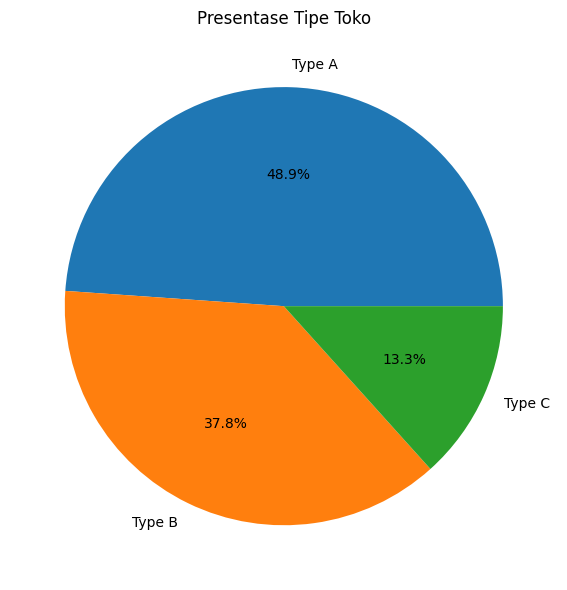

In [35]:
labels = ["Type A", "Type B","Type C"]
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(dfstores["Type"].value_counts(), labels=labels, autopct='%.1f%%')
ax.set_title('Presentase Tipe Toko')
plt.tight_layout()

Tipe toko yang mendominasi adalah type A dalam penjualan sebesar 48.9%

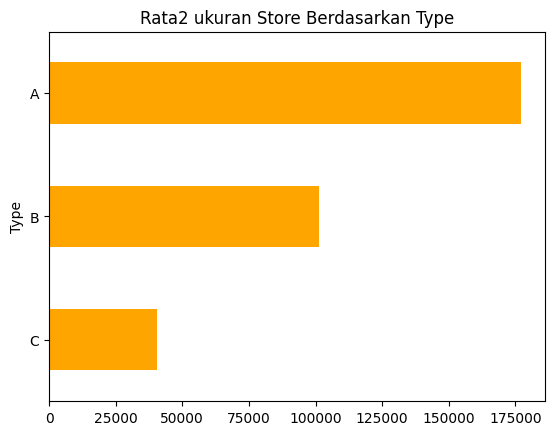

In [47]:
dfpresentasetype = dfstores.groupby(by="Type")["Size"].mean()
dfpresentasetype.plot.barh(x="Type", color="orange", legend=False)
plt.gca().invert_yaxis()
plt.title("Rata2 ukuran Store Berdasarkan Type")
plt.show()

Ukuran / size toko didominasi oleh tipe a dengan size rata-rata mencapai 17500

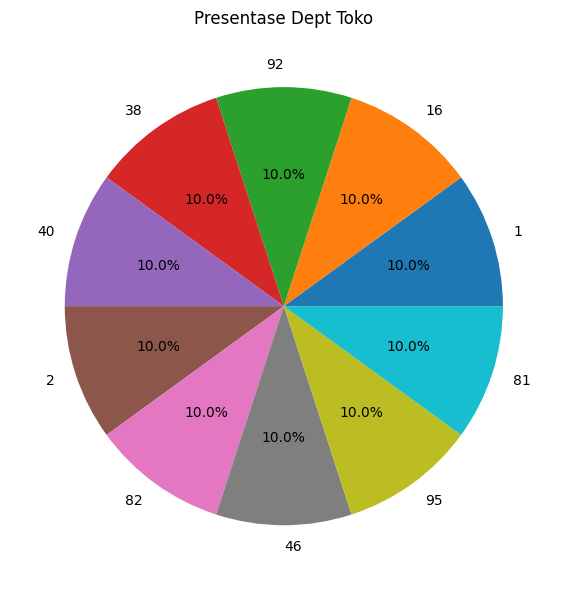

In [134]:
labels = dftrain["Dept"].value_counts()[:10].index
values = dftrain["Dept"].value_counts()[:10].values
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(values, labels=labels, autopct='%.1f%%')
ax.set_title('Presentase Dept Toko')
plt.tight_layout()

proposi dari departemen rata-rata adalah sama

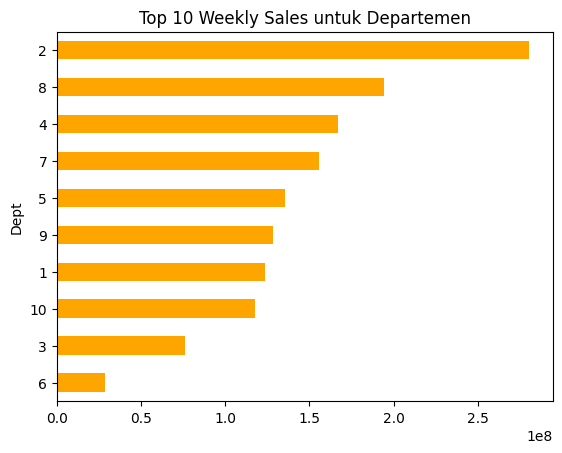

In [87]:
dfhighlyweeklysales = dftrain.groupby(by="Dept")["Weekly_Sales"].sum()[:10].sort_values(ascending=False)
dfhighlyweeklysales.plot.barh(x="Dept", color="orange", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 Weekly Sales untuk Departemen")
plt.show()

berdasarkan weekly sales departemen dengan kode 2 menempati total penjualan tertinggi 

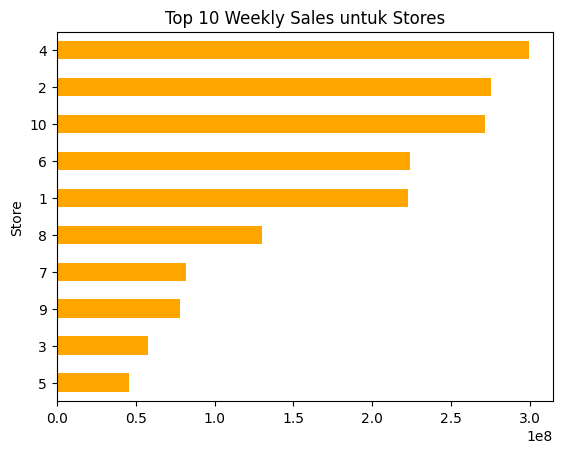

In [56]:
dfhighlyweeklysales = dftrain.groupby(by="Store")["Weekly_Sales"].sum()[:10].sort_values(ascending=False)
dfhighlyweeklysales.plot.barh(x="Store", color="orange", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 Weekly Sales untuk Stores")
plt.show()

berdasarkan weekly sales stores dengan kode 4 menempati total penjualan tertinggi 

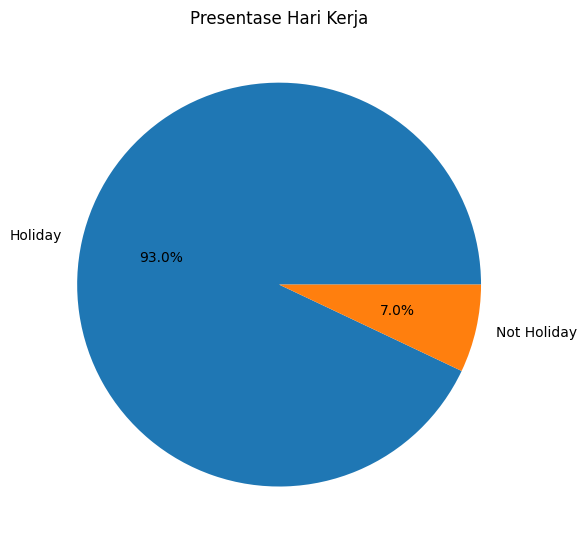

In [58]:
dfoperation = dftrain["IsHoliday"].value_counts()
labels = ["Holiday", "Not Holiday"]
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(dfoperation, labels=labels, autopct='%.1f%%')
ax.set_title('Presentase Hari Kerja')
plt.tight_layout()

Presentase hari penjualan didominasi oleh holiday

<Figure size 1000x600 with 0 Axes>

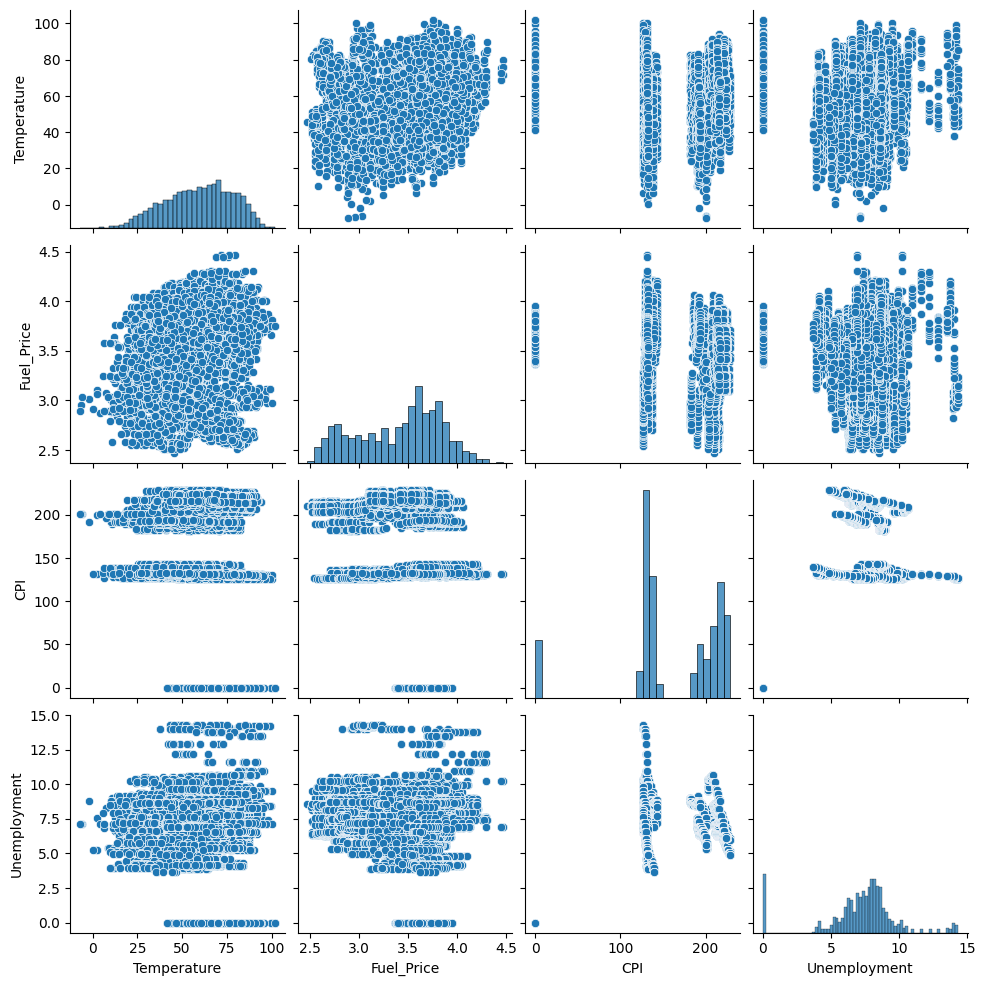

In [64]:
plt.figure(figsize = (10,6))
dfcompare = datamerge[["Temperature","Fuel_Price", "CPI","Unemployment"]]
sns.pairplot(dfcompare)

Dengan keempat feature yaitu temp, harga bahan bakar, cpi dan unemployment dapat dikatakan tidak ada hubungan signifikan dari plot yang tidak membentuk apapun

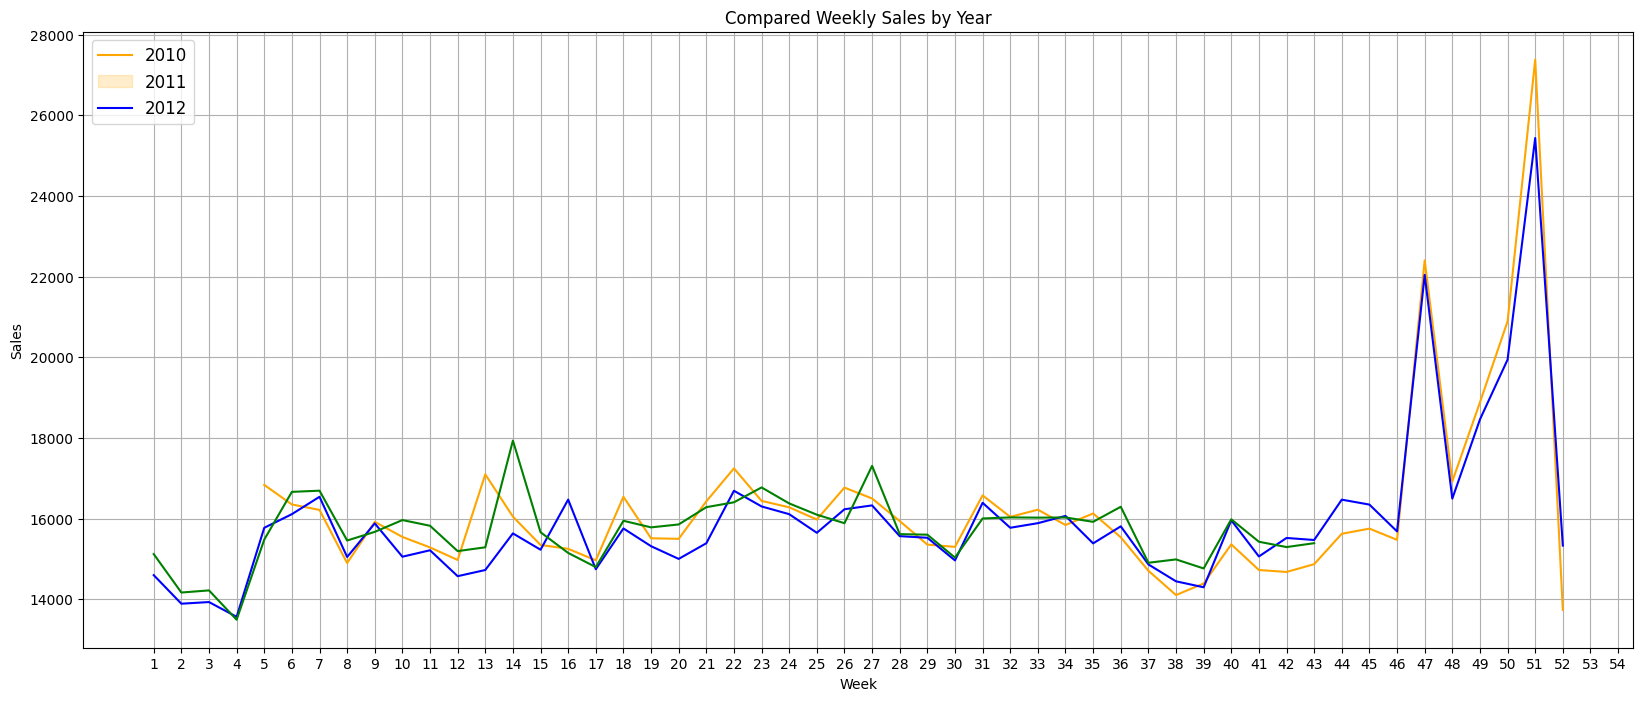

In [86]:
#weekly sales in 2010,2011,2012
dftrain['Tahun'] = pd.to_datetime(dftrain['Date']).dt.year
dftrain["Minggu"] = pd.to_datetime(dftrain["Date"]).dt.week

plt.figure(figsize=(20,8))
weeksales2010 = dftrain[dftrain['Tahun']==2010]['Weekly_Sales'].groupby(dftrain['Minggu']).mean()
weeksales2011 = dftrain[dftrain['Tahun']==2011]['Weekly_Sales'].groupby(dftrain['Minggu']).mean()
weeksales2012 = dftrain[dftrain['Tahun']==2012]['Weekly_Sales'].groupby(dftrain['Minggu']).mean()


sns.lineplot(x=weeksales2010.index,y=weeksales2010.values, color="orange")
sns.lineplot(x=weeksales2011.index,y=weeksales2011.values, color="blue")
sns.lineplot(x=weeksales2012.index,y=weeksales2012.values, color="green")

plt.grid()
plt.xticks(np.arange(1,55, step=1))
plt.legend(["2010","2011","2012"], loc="best", fontsize=12)
plt.title("Compared Weekly Sales by Year")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.show()

berdasarkan data pertahun, weekly sales terbesar adalah pdaa minggu ke 51 terjadi peningkatan penjualan signifikan, dan minggu ke 52 terjadi penrunan tajam, perusahaan harus mampu menganalisis penyebab penurunan ini 

Building model

Menggabungkan data yang akan digunakan untuk membuat model ML

In [93]:
datamerge.head()
trainmerge = dftrain.merge(datamerge, how='inner', on=['Store', 'Date', 'IsHoliday','Tahun']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
testmerge = dftest.merge(datamerge, how="inner", on = ['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)


,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Tahun
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,2012
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,2012
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,2012
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,2012
4,1,1,2012-11-30,False,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,A,151315,2012


In [94]:
trainmerge = trainmerge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
testmerge = testmerge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

Splitting train and test (proporsi test 30%)

In [97]:
X = trainmerge[['Store','Dept','IsHoliday','Size','Minggu','Tahun']] # Selecting the values to be taken in the X
y = trainmerge['Weekly_Sales'] 

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
#print(X.info())
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      421570 non-null  int64
 1   Dept       421570 non-null  int64
 2   IsHoliday  421570 non-null  bool 
 3   Size       421570 non-null  int64
 4   Minggu     421570 non-null  int64
 5   Tahun      421570 non-null  int64
dtypes: bool(1), int64(5)
memory usage: 16.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295099 entries, 338670 to 121958
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      295099 non-null  int64
 1   Dept       295099 non-null  int64
 2   IsHoliday  295099 non-null  bool 
 3   Size       295099 non-null  int64
 4   Minggu     295099 non-null  int64
 5   Tahun      295099 non-null  int64
dtypes: bool(1), int64(5)
memory usage: 13.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64In

Pelatihan dan Pengujian data Menggunakan Ridge Regression

In [104]:
#Ridge regression
params = {'alpha' : [ 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
ridge_regressor = GridSearchCV(Ridge(), params, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
             scoring='neg_mean_absolute_error')

In [105]:
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)

In [107]:
print("Hasil train model")
print("Root Mean Squared Error: ", mse(y_train.values, y_train_pred, squared=False))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))
print("Hasil test model")
print("Root Mean Squared Error: ", mse(y_test.values, y_test_pred, squared=False))
print("R-Squared: ", r2_score(y_test.values, y_test_pred))

Hasil train model
Root Mean Squared Error:  21696.189989134735
R-Squared:  0.08442134387348998
Hasil test model
Root Mean Squared Error:  21811.998658223216
R-Squared:  0.08452464107207469


Pelatihan dan Pengujian data Menggunakan Lasso Regression

In [119]:
params = {'alpha' : [ 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
lasso_regressor = GridSearchCV(Lasso(), params, cv =10, scoring = 'neg_mean_absolute_error', n_jobs = -1)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
             scoring='neg_mean_absolute_error')

In [120]:
y_train_pred = lasso_regressor.predict(X_train)
y_test_pred = lasso_regressor.predict(X_test)

In [121]:
print("Hasil train model lasso")
print("Root Mean Squared Error: ", mse(y_train.values, y_train_pred, squared=False))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))
print("Hasil test model cv 10")
print("Root Mean Squared Error: ", mse(y_test.values, y_test_pred, squared=False))
print("R-Squared: ", r2_score(y_test.values, y_test_pred))

Hasil train model lasso
Root Mean Squared Error:  21723.957824682093
R-Squared:  0.0820762402614238
Hasil test model cv 10
Root Mean Squared Error:  21841.525616257724
R-Squared:  0.08204440081236186


Pelatihan dan Pengujian data Menggunakan Decision Tree Regression

In [122]:
print("Decision Tree Regression")
depth = list(range(3,30))
param_grid = dict(max_depth = depth)
dectree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
dectree.fit(X_train,y_train)

Decision Tree Regression


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [123]:
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

In [127]:
print("Hasil train model decision tree")
print("Root Mean Squared Error: ", mse(y_train.values, y_train_pred, squared=False))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))
print("Hasil test model cv 10")
print("Root Mean Squared Error: ", mse(y_test.values, y_test_pred, squared=False))
print("R-Squared: ", r2_score(y_test.values, y_test_pred))

Hasil train model decision tree
Root Mean Squared Error:  1669.9522330272496
R-Squared:  0.9945757861018945
Hasil test model cv 10
Root Mean Squared Error:  4925.8791825475255
R-Squared:  0.9533100675100651


Pelatihan dan Pengujian data Menggunakan Random Forrest Regression

In [126]:
print("Random Forrest Regressor")
tuned_params = {'n_estimators': [100, 200], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}  
randomreg = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 3, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
randomreg.fit(X_train, y_train)

Random Forrest Regressor


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   scoring='neg_mean_absolute_error')

In [128]:
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

In [129]:
print("Hasil train model random forrest")
print("Root Mean Squared Error: ", mse(y_train.values, y_train_pred, squared=False))
print("R-Squared: ", r2_score(y_train.values, y_train_pred))
print("Hasil test model cv 10")
print("Root Mean Squared Error: ", mse(y_test.values, y_test_pred, squared=False))
print("R-Squared: ", r2_score(y_test.values, y_test_pred))

Hasil train model random forrest
Root Mean Squared Error:  1669.9522330272496
R-Squared:  0.9945757861018945
Hasil test model cv 10
Root Mean Squared Error:  4925.8791825475255
R-Squared:  0.9533100675100651


Membandingkan dan Memilih Model 

In [133]:
Compared = {
    'Model': ['RidgeRegression', 'LassoRegresion', 'DecisionTreeRegressor', 'RandomForrestRegressor'],
    'RMSE Train': [21696.189989134735, 21723.957824682093, 1669.9522330272496, 1669.9522330272496],
    'RMSE Test': [21811.998658223216, 21841.525616257724, 4925.8791825475255, 4925.8791825475255],
    'RSquared Train': [0.08442134387348998, 0.0820762402614238, 0.9945757861018945, 0.9945757861018945],
    'RSquared Test': [0.08452464107207469, 0.08204440081236186,0.9533100675100651 , 0.9533100675100651]

}
dfcomparemodel = pd.DataFrame(Compared)
dfcomparemodel

,Model,RMSE Train,RMSE Test,RSquared Train,RSquared Test
0,RidgeRegression,21696.189989,21811.998658,0.084421,0.084525
1,LassoRegresion,21723.957825,21841.525616,0.082076,0.082044
2,DecisionTreeRegressor,1669.952233,4925.879183,0.994576,0.953310
3,RandomForrestRegressor,1669.952233,4925.879183,0.994576,0.953310


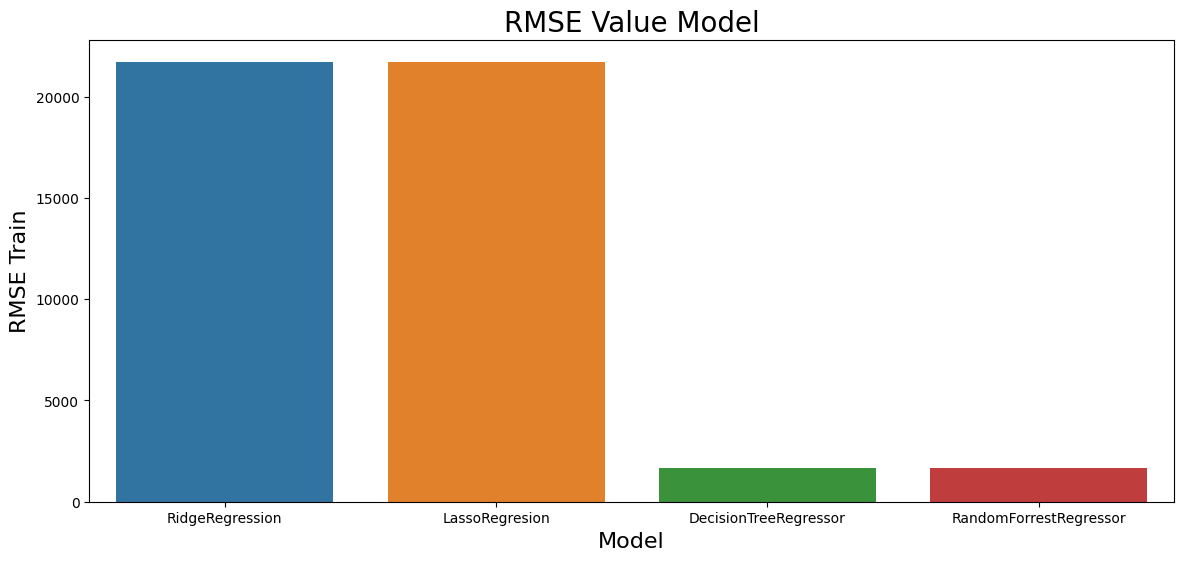

In [136]:
plt.figure(figsize=(14,6))
sns.barplot(x="Model", y = "RMSE Train", data=dfcomparemodel)
plt.title('RMSE Value Model', fontsize=20)
plt.xlabel('Model', fontsize=16)
plt.ylabel('RMSE Train', fontsize=16)
plt.show()

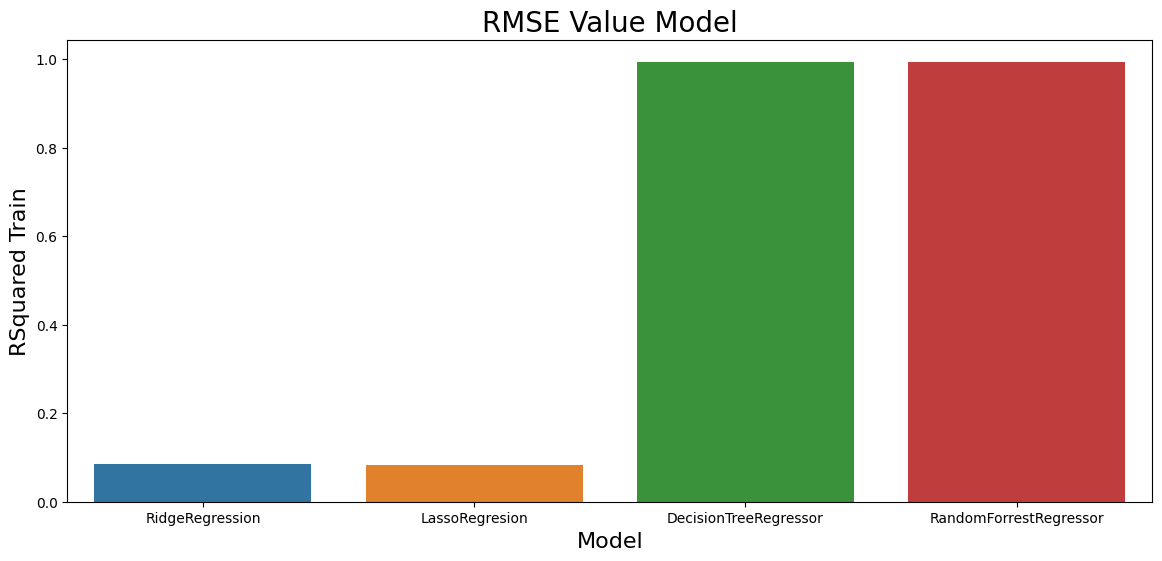

In [137]:
plt.figure(figsize=(14,6))
sns.barplot(x="Model", y = "RSquared Train", data=dfcomparemodel)
plt.title('RMSE Value Model', fontsize=20)
plt.xlabel('Model', fontsize=16)
plt.ylabel('RSquared Train', fontsize=16)
plt.show()

Model yang cocok digunakan adalah DecissionTreeRegressor ataupun randomforrestregressor hal ini dikarenakan nilai untuk RMSE baik untuk train maupun test cenderung rendah dan nilai r squared yang tinggi atau mendekati angka 1.